In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.5f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

✅ 최종 선정 컬럼

| Feature |
|---------|
| `SCRB_PATH_NM_GRP` |
| `INHOME_RATE` |
| `TOTAL_USED_DAYS` |
| `CH_LAST_DAYS_BF_GRP` |
| `STB_RES_1M_YN` |
| `AGMT_KIND_NM` |
| `BUNDLE_YN` |
| `TV_I_CNT` |
| `AGMT_END_SEG` |
| `AGE_GRP10` |
| `VOC_STOP_CANCEL_MONTH1_YN` |
| `CH_HH_AVG_MONTH1` |
| `MONTHS_REMAINING` |
| `PROD_NM_GRP` |
| `MEDIA_NM_GRP` |
| `VOC_TOTAL_MONTH1_YN` |


#### 📌 모델 성능 비교 및 최종 모델 선정

##### 🔍 모델 성능 비교 결과
여러 가지 머신러닝 모델(로지스틱 회귀, 랜덤 포레스트, XGBoost, LightGBM, CatBoost 등)을 활용하여 **2차 선정된 피처들로 모델링을 진행**한 결과, 전반적으로 **LightGBM(LGBM)과 CatBoost 모델이 가장 우수한 성능을 보여주었음.**

##### ✅ **최종 모델 결정**
다양한 실험 결과를 바탕으로 **LightGBM과 CatBoost 모델을 최종적으로 선택**하여 전체 데이터를 활용한 모델링을 진행해 볼 예정!


---

최종 선정된 컬럼들로 이루어진 csv 파일 생성

In [2]:
df_real = pd.read_csv("data/full_data/TPS_cancel_data_FeatureEngineering_end.csv")

In [3]:
df = df_real.filter(items=['sha2_hash','MEDIA_NM_GRP','PROD_NM_GRP','AGMT_KIND_NM','STB_RES_1M_YN',
                 'SCRB_PATH_NM_GRP','INHOME_RATE','AGMT_END_SEG','TOTAL_USED_DAYS','BUNDLE_YN',
                 'TV_I_CNT','CH_LAST_DAYS_BF_GRP','VOC_TOTAL_MONTH1_YN','VOC_STOP_CANCEL_MONTH1_YN','AGE_GRP10',
                 'CH_HH_AVG_MONTH1','MONTHS_REMAINING','p_mt','churn'])

In [ ]:
df.to_csv("data/full_data/TPS_cancel_data_Final.csv", index=False)

---

### LightGBM VS CatBoost

In [4]:
# 2월 ~ 9월 train
# 10월 val
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])]
val = df[df['p_mt'] == 10]
test = df[df['p_mt'] == 11]

In [5]:
train

,sha2_hash,MEDIA_NM_GRP,PROD_NM_GRP,AGMT_KIND_NM,STB_RES_1M_YN,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,N,I/B,10.00,약정만료전 12개월이상,733,Y,3.00,3개월내없음,N,N,60대,0.00,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,Y,I/B,0.00,약정만료전 9~12개월,764,Y,3.00,일주일내,Y,N,60대,6.72,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,N,I/B,10.00,약정만료전 9~12개월,794,Y,3.00,3주일전,N,N,60대,9.86,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,N,I/B,10.00,약정만료전 9~12개월,825,Y,3.00,4주일전,N,N,60대,5.95,10,5,N
4,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,HD,이코노미,신규,N,I/B,0.00,약정만료전 6~9개월,855,Y,3.00,일주일내,N,N,60대,4.03,9,6,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483371,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,HD,베이직,신규,N,현장경로,10.00,약정만료후 12개월이상,2246,N,1.00,일주일내,N,N,50대,3.67,-37,5,N
21483372,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,HD,베이직,신규,N,현장경로,10.00,약정만료후 12개월이상,2276,N,1.00,일주일내,N,N,50대,3.14,-38,6,N
21483373,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,HD,베이직,신규,N,현장경로,10.00,약정만료후 12개월이상,2307,N,1.00,일주일내,N,N,50대,4.10,-39,7,N
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,HD,베이직,신규,N,현장경로,10.00,약정만료후 12개월이상,2338,N,1.00,일주일내,N,N,50대,2.03,-40,8,N


In [6]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


In [7]:
train = train.drop(columns=['sha2_hash','p_mt'])
val = val.drop(columns=['sha2_hash','p_mt'])
test = test.drop(columns=['sha2_hash','p_mt'])

In [8]:
from imblearn.under_sampling import RandomUnderSampler

X = train.drop(columns = ['churn'])
y = train['churn']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [9]:
print("Before RU:")
print(y.value_counts())

print("\nAfter RU:")
print(pd.Series(y_resampled).value_counts())

Before RU:
churn
N    15541330
Y      105706
Name: count, dtype: int64

After RU:
churn
N    105706
Y    105706
Name: count, dtype: int64


In [10]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='churn')

resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

In [11]:
train = resampled_data

In [12]:
categorical_cols = train.select_dtypes(include=['object']).columns

# Train에는 없고 Validation에만 있는 값 찾기
unseen_values = {}

for col in categorical_cols:
    train_unique = set(train[col].unique())
    val_unique = set(val[col].unique())

    unseen = val_unique - train_unique
    if unseen:
        unseen_values[col] = unseen

# 결과 출력
print(unseen_values)

{'PROD_NM_GRP': {'기타'}, 'INHOME_RATE': {'100.0'}, 'AGE_GRP10': {'10대'}}


In [13]:
val = val[val['PROD_NM_GRP'] != '기타'].reset_index(drop=True)
test = test[test['PROD_NM_GRP'] != '기타'].reset_index(drop=True)

val = val[val['INHOME_RATE'] != '100.0'].reset_index(drop=True)
test = test[test['INHOME_RATE'] != '100.0'].reset_index(drop=True)

val = val[val['AGE_GRP10'] != '10대'].reset_index(drop=True)
test = test[test['AGE_GRP10'] != '10대'].reset_index(drop=True)

In [14]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [15]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1','MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


LightGBM 학습

In [16]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Validation Accuracy: 0.82

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1934302
           1       0.03      0.72      0.05     14325

    accuracy                           0.82   1948627
   macro avg       0.51      0.77      0.48   1948627
weighted avg       0.99      0.82      0.89   1948627


Confusion Matrix (Validation):
[[1579450  354852]
 [   3956   10369]]


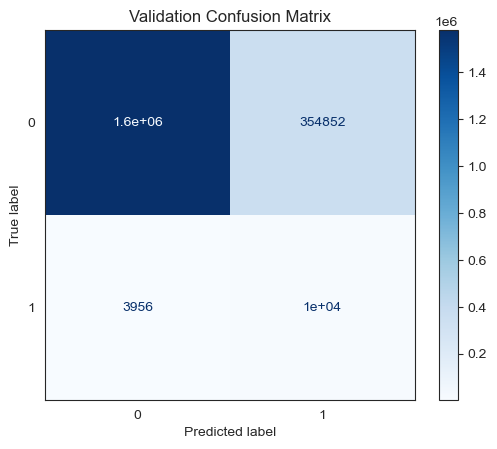

Validation AUC-ROC: 0.85


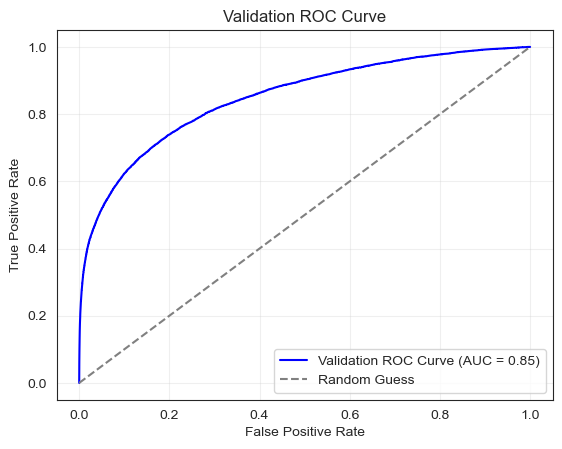

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = lgbm_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgbm_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = lgbm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---

CatBoost 학습

In [28]:
from catboost import CatBoostClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 기본값을 사용한 CatBoost 모델 생성
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

# 모델 학습
cat_model.fit(X_train, y_train)

0:	learn: 0.6795182	total: 192ms	remaining: 3m 12s
1:	learn: 0.6670352	total: 230ms	remaining: 1m 54s
2:	learn: 0.6556548	total: 266ms	remaining: 1m 28s
3:	learn: 0.6449718	total: 303ms	remaining: 1m 15s
4:	learn: 0.6357630	total: 330ms	remaining: 1m 5s
5:	learn: 0.6267590	total: 365ms	remaining: 1m
6:	learn: 0.6185426	total: 403ms	remaining: 57.2s
7:	learn: 0.6107438	total: 433ms	remaining: 53.7s
8:	learn: 0.6035608	total: 470ms	remaining: 51.7s
9:	learn: 0.5970639	total: 506ms	remaining: 50.1s
10:	learn: 0.5909496	total: 531ms	remaining: 47.8s
11:	learn: 0.5853935	total: 563ms	remaining: 46.4s
12:	learn: 0.5802090	total: 599ms	remaining: 45.5s
13:	learn: 0.5757966	total: 628ms	remaining: 44.3s
14:	learn: 0.5713485	total: 659ms	remaining: 43.3s
15:	learn: 0.5671998	total: 696ms	remaining: 42.8s
16:	learn: 0.5632594	total: 726ms	remaining: 42s
17:	learn: 0.5595810	total: 761ms	remaining: 41.5s
18:	learn: 0.5562216	total: 801ms	remaining: 41.4s
19:	learn: 0.5533095	total: 841ms	remainin

Validation Accuracy: 0.82

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1934302
           1       0.03      0.72      0.05     14325

    accuracy                           0.82   1948627
   macro avg       0.51      0.77      0.48   1948627
weighted avg       0.99      0.82      0.89   1948627


Confusion Matrix (Validation):
[[1580055  354247]
 [   3953   10372]]


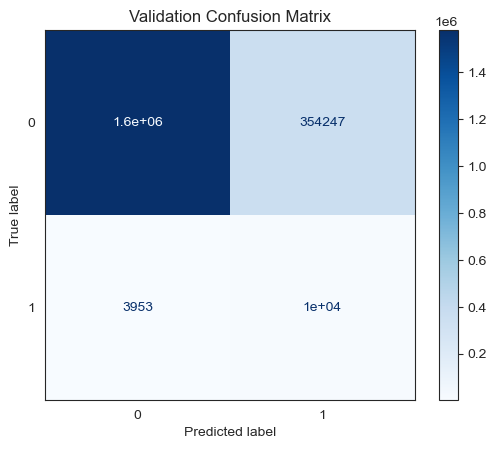

Validation AUC-ROC: 0.85


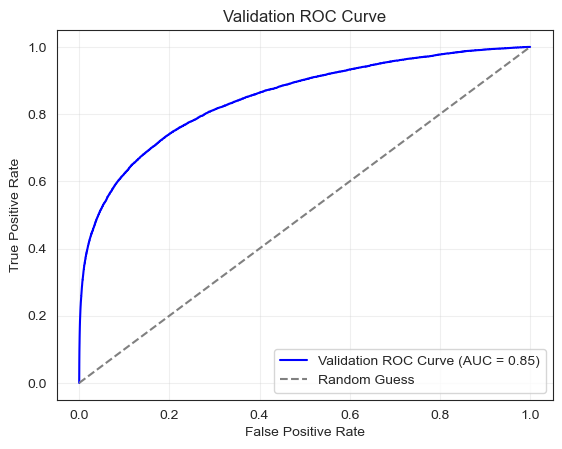

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

CatBoost가 살짝 더 성능이 좋다고 나온다.<br><br>
둘의 성능이 비슷하다.

---

실제 상황에 대비해서, 5:5 비율이 아닌 6:4 비율 + 가중치를 해보는게 어떨까?

In [80]:
# 2월 ~ 9월 train
# 10월 val
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])]
val = df[df['p_mt'] == 10]
test = df[df['p_mt'] == 11]


train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)


train = train.drop(columns=['sha2_hash','p_mt'], axis=1)
val = val.drop(columns=['sha2_hash','p_mt'], axis=1)
test = test.drop(columns=['sha2_hash','p_mt'], axis=1)


object
object
object


6:4 비율

In [81]:
from sklearn.utils import resample

# 데이터 분리
df_Y = train[train['churn'] == 'Y']
df_N = train[train['churn'] == 'N']

# Y의 데이터 개수와 비율에 따른 N의 샘플 개수 계산
y_count = len(df_Y)  # Y 데이터 개수
n_count_target = int((6 / 4) * y_count)  # 6:4 비율로 N 데이터 개수 계산

# N 데이터를 랜덤 샘플링
df_N_downsampled = resample(
    df_N,
    replace=False,  # 복원 샘플링 하지 않음
    n_samples=n_count_target,  # 목표 샘플 개수
    random_state=42  # 재현성을 위한 시드
)

# 언더샘플링된 데이터 결합
train_balanced = pd.concat([df_Y, df_N_downsampled])

# 결과 섞기 (선택 사항)
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 결과 확인
print("최종 데이터 분포:")
print(train_balanced['churn'].value_counts())

train = train_balanced

최종 데이터 분포:
churn
N    158559
Y    105706
Name: count, dtype: int64


In [82]:
categorical_cols = train.select_dtypes(include=['object']).columns

# Train에는 없고 Validation에만 있는 값 찾기
unseen_values = {}

for col in categorical_cols:
    train_unique = set(train[col].unique())
    val_unique = set(val[col].unique())

    unseen = val_unique - train_unique
    if unseen:
        unseen_values[col] = unseen

# 결과 출력
print(unseen_values)

{'PROD_NM_GRP': {'기타'}, 'INHOME_RATE': {'100.0'}}


In [83]:
val = val[val['PROD_NM_GRP'] != '기타'].reset_index(drop=True)
test = test[test['PROD_NM_GRP'] != '기타'].reset_index(drop=True)

val = val[val['INHOME_RATE'] != '100.0'].reset_index(drop=True)
test = test[test['INHOME_RATE'] != '100.0'].reset_index(drop=True)

In [84]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [85]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1','MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


LightGBM

In [86]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

Validation Accuracy: 0.82

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1934319
           1       0.03      0.73      0.05     14325

    accuracy                           0.82   1948644
   macro avg       0.51      0.77      0.48   1948644
weighted avg       0.99      0.82      0.89   1948644


Confusion Matrix (Validation):
[[1579140  355179]
 [   3918   10407]]


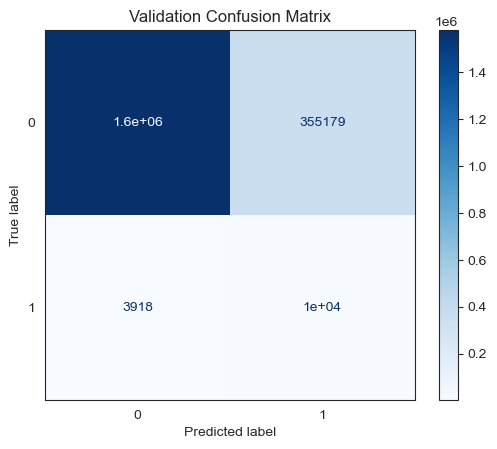

Validation AUC-ROC: 0.85


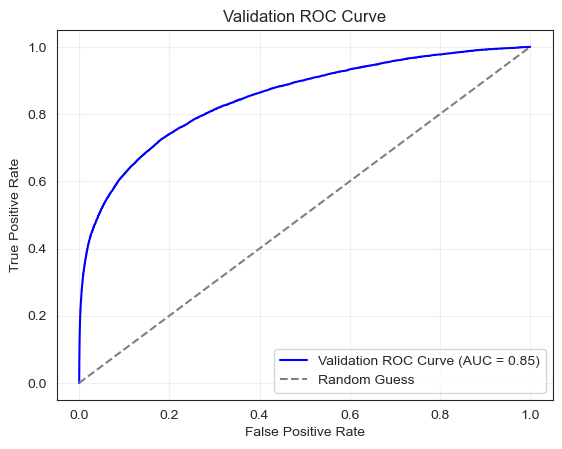

In [87]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = lgbm_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgbm_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = lgbm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

CatBoost 학습

In [38]:
from catboost import CatBoostClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 종속 변수 분포 확인
class_counts = np.bincount(y_train)  # 0과 1 클래스 개수 계산
class_ratio = class_counts[0] / class_counts[1]  # 클래스 비율 계산

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42,
    scale_pos_weight=class_ratio  # 클래스 비율을 가중치로 적용
)

cat_model.fit(X_train, y_train)

0:	learn: 0.6794337	total: 32.2ms	remaining: 32.2s
1:	learn: 0.6670013	total: 63.4ms	remaining: 31.6s
2:	learn: 0.6553830	total: 90.8ms	remaining: 30.2s
3:	learn: 0.6446579	total: 129ms	remaining: 32.2s
4:	learn: 0.6348375	total: 167ms	remaining: 33.2s
5:	learn: 0.6258620	total: 193ms	remaining: 31.9s
6:	learn: 0.6175497	total: 222ms	remaining: 31.4s
7:	learn: 0.6099007	total: 252ms	remaining: 31.2s
8:	learn: 0.6030887	total: 286ms	remaining: 31.5s
9:	learn: 0.5965178	total: 334ms	remaining: 33s
10:	learn: 0.5905647	total: 372ms	remaining: 33.4s
11:	learn: 0.5852794	total: 434ms	remaining: 35.8s
12:	learn: 0.5804950	total: 469ms	remaining: 35.6s
13:	learn: 0.5758990	total: 512ms	remaining: 36.1s
14:	learn: 0.5713096	total: 552ms	remaining: 36.2s
15:	learn: 0.5670874	total: 578ms	remaining: 35.5s
16:	learn: 0.5631954	total: 602ms	remaining: 34.8s
17:	learn: 0.5596182	total: 630ms	remaining: 34.4s
18:	learn: 0.5567200	total: 660ms	remaining: 34.1s
19:	learn: 0.5535000	total: 687ms	remain

Validation Accuracy: 0.82

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1934319
           1       0.03      0.72      0.06     14325

    accuracy                           0.82   1948644
   macro avg       0.51      0.77      0.48   1948644
weighted avg       0.99      0.82      0.89   1948644


Confusion Matrix (Validation):
[[1582846  351473]
 [   3976   10349]]


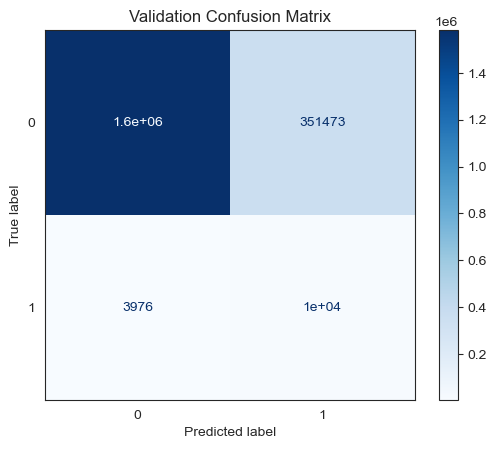

Validation AUC-ROC: 0.85


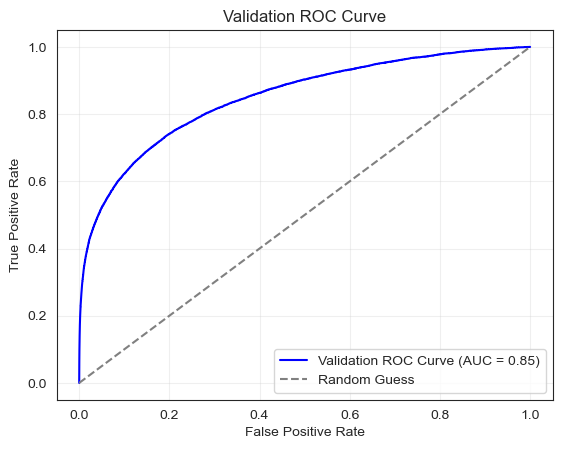

In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


실제 상황에 더 맞게 6:4 비율로 하고, 가중치를 적용했을 때는 LightGBM이 더 나은 성능을 보임. <br><br>
이를 실제 상황과 비슷하게 만들기 위해 6:4 비율로 언더 샘플링을 진행하고 가중치를 적용했을 때, 더 나은 성능을 보임!

---

앙상블 모델을 적용해보자.   
LightGBM이 좀 더 모델에 영향을 있게 앙상블 진행

In [46]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성 및 학습
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# CatBoost 모델 생성 및 학습
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    random_seed=42,
    scale_pos_weight=np.bincount(y_train)[0] / np.bincount(y_train)[1],  # 클래스 불균형 보정
    verbose=0  # 학습 로그 출력 안함
)
cat_model.fit(X_train, y_train)

# -----------------------------------------------------------
# 예측 (Validation 데이터)
# -----------------------------------------------------------
# 개별 모델 예측 (확률 예측)
lgbm_preds = lgbm_model.predict_proba(X_val)[:, 1]  # LightGBM 확률 예측
cat_preds = cat_model.predict_proba(X_val)[:, 1]  # CatBoost 확률 예측

# ✅ LightGBM의 영향을 더 크게 반영한 가중 평균 앙상블
ensemble_preds = (0.8 * lgbm_preds) + (0.2 * cat_preds)

# 최종 예측 (Threshold = 0.5)
final_preds = (ensemble_preds >= 0.5).astype(int)

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.90   1934319
           1       0.03      0.73      0.05     14325

    accuracy                           0.81   1948644
   macro avg       0.51      0.77      0.48   1948644
weighted avg       0.99      0.81      0.89   1948644


Confusion Matrix (Validation):
[[1576057  358262]
 [   3927   10398]]


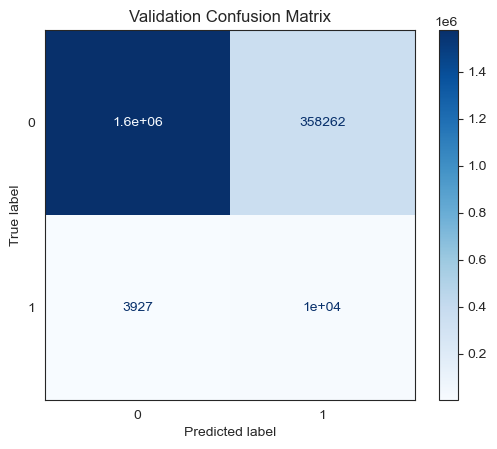

Validation AUC-ROC: 0.85


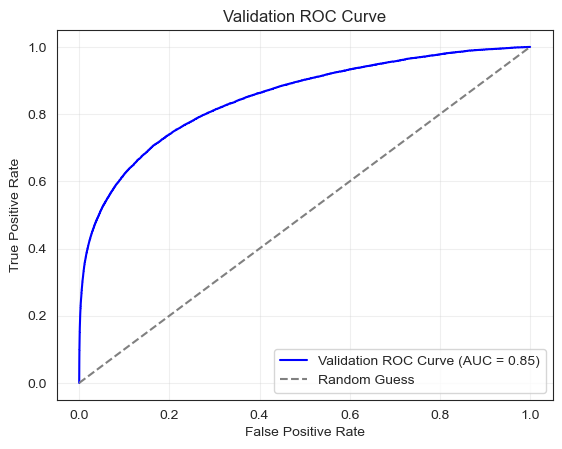

In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---

### 📌 랜덤 언더샘플링(6:4) 적용 후 LightGBM 최종 선택

### ✅ **1. 모델 선택 과정**
- 여러 모델(XGBoost, CatBoost, LightGBM 등)을 테스트한 결과,  
  **6:4 비율로 랜덤 언더샘플링을 적용한 LightGBM이 가장 우수한 성능을 보임**.
- 특히, **CatBoost보다 LightGBM이 살짝 더 높은 성능을 기록**하여 최종 모델로 선정

---

### 🔍 **2. 왜 6:4 비율로 랜덤 언더샘플링을 했는가?**
#### 🔹 **기존 5:5 샘플링의 문제점**
- 5:5 샘플링은 **해지(1)와 유지(0)의 개수를 동일하게 맞추는 방식**이지만,  
  실제 서비스에서는 **유지(0) 고객이 훨씬 많음**.
- 이로 인해 **FN(False Negative, 실제 해지 고객을 모델이 유지로 예측하는 경우)가 충분히 줄어들지 않음**.

#### 🔹 **6:4 샘플링이 더 효과적인 이유**
- **실제 환경과 비슷한 데이터 분포 반영**  
  - 해지(1) 고객을 기준으로 유지(0) 데이터를 **6:4 비율로 샘플링**하여,  
    **현실적인 해지 비율을 학습할 수 있도록 조정**.

- **FN(False Negative) 감소 → 해지 고객을 더 잘 예측**  
  - 기존 5:5에서는 FN이 충분히 줄지 않았으나,  
    **6:4 샘플링을 적용하니 FN이 더 감소하는 효과를 보임**.

- **FP(False Positive)는 살짝 증가하지만, 프로젝트 목적에 부합**  
  - FP(잘못된 해지 예측)는 소폭 증가하지만,     
    **FP는 그저 경고로 끝날 수 있는 부분이므로 큰 문제는 되지 않음**.  
  - 반면, **FN(실제 해지 고객을 놓치는 것)은 고객 이탈을 직접적으로 유발하므로,  
    FN을 줄이는 것이 비즈니스적으로 훨씬 중요한 목표**.

---

### 🚀 **3. 최종 결론**
- **6:4 랜덤 언더샘플링을 적용한 LightGBM이 최적의 모델**  
  - CatBoost보다 성능이 소폭 더 우수했으며,  
    **FN을 효과적으로 줄이면서도 실전 적용 가능성이 높은 모델이었음**.
- **FN을 줄이는 것이 핵심 목표이므로, FP의 소폭 증가보다 FN 감소가 더 중요함**.
